In [1]:
# import packages
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm
from adjustText import adjust_text
import os

from statannotations.Annotator import Annotator

In [2]:
# Load data 
output_dir = '../../LCMS/'

# Load the Excel file
excel_file = os.path.join(output_dir, '7372.SUB14737_MetabolomicsData.xlsx')

# Load the sheet into a DataFrame
sheet_name = 'Untargeted'  # Replace with the actual sheet name if different
data = pd.read_excel(excel_file, sheet_name=sheet_name)
metadata = pd.read_excel(excel_file, sheet_name='SamplesNames')

/Users/djuna/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [3]:
# Are there any annotations based on the blank used for background subtraction?

# I don't see any extraction blank columns so we don't have to check for higher signal in the non-blanks vs the blanks
'Background' in set(data.iloc[:,2].unique())


False

In [6]:
set(data.iloc[:,2].unique())

{'Bad integration;FISHhit',
 'Bad integration;Level 1 ID',
 'FISHhit',
 'FISHhit;Top PLS compound',
 'Level 1 ID',
 'Level 2 ID',
 'MasslistRT ID',
 'Other ID',
 'Tags',
 'Tags\nImportant, please read report',
 'Top PLS compound',
 'Weak/poor match',
 'Weak/poor match;Bad integration',
 'Weak/poor match;Top PLS compound',
 nan}

In [13]:
# get metadata
meta = metadata.iloc[2:]
meta.columns = metadata.iloc[1]
dictionary = dict(zip(meta['CD file'], meta['Group']))


In [24]:
# get the normalized areas
norm_areas = data.iloc[6:,31:42]
norm_areas.columns = [x.split('(')[1].split(')')[0] for x in norm_areas.iloc[0].values]
norm_areas = norm_areas[1:]
norm_areas.index = np.arange(len(norm_areas))
names = np.array([dictionary[x] for x in norm_areas.columns])


In [32]:
# remove blank
norm_areas_no_blank = norm_areas.iloc[:,names!='ExtBlank']
ext_blank = norm_areas.iloc[:, names == 'ExtBlank'].squeeze()
result_df = norm_areas_no_blank.subtract(ext_blank, axis=0)
names_no_blank = names[names!='ExtBlank']

In [58]:
# This creates a boolean mask that is True for rows where all values are > 0.
mask = (result_df > 0).all(axis=1)

# Use the mask to select rows from result_df
selected_rows = result_df[mask]

selected_rows

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
1,9117531.650249,12528944.233749,232870662.263496,16853647.993981,25421392.380027,10734728.381227,16964287.950113,16343016.484643,15760297.276799,16303745.420189
4,37698917.959496,45707246.557652,7782305.892948,55982358.054639,20136729.918857,40684291.590245,56907507.064254,33357785.595338,45688931.271037,49357775.894146
12,2459048.77203,5210282.578706,5493369.157989,5206032.90007,2918869.0426,9730988.886552,7837169.62543,12217512.695739,9823057.855,15214581.969832
21,5155867.007888,8037535.557784,2945064.607042,1685996.536614,2184252.774745,1387677.502731,8730951.943295,1257412.205201,2696757.974981,798609.186589
26,10011970.852367,9428507.436679,836052.479575,14481470.850353,3666200.221935,5754720.981252,13305408.67267,13860582.506097,11634962.883004,11988465.713385
...,...,...,...,...,...,...,...,...,...,...
1253,119460.56917,136662.109672,54935.925564,901989.602502,525243.1093,205651.938023,184503.362798,187572.179722,255449.753195,212716.241894
1256,433421.158726,79700.686134,466114.824515,639179.966314,213750.100768,351377.620077,550051.669565,155549.045633,669899.133338,513914.258579
1257,68318.301387,108084.065434,156905.015873,214830.753333,64174.805847,196221.358284,197199.087597,266162.995893,152756.968585,80156.842935
1262,48348.267248,83893.079733,45473.557061,61858.304199,66382.777605,212949.926703,79605.568025,75153.320872,159830.995177,100335.249662


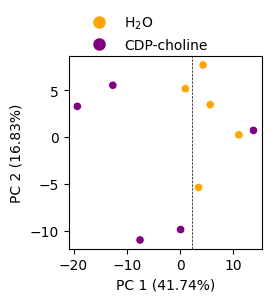

In [59]:
# only look at E3 vs G2


# perform PCA
scaler = StandardScaler()
norm_areas_subset_no_background_scaled = scaler.fit_transform(selected_rows.T)

pca = PCA(n_components=4)
principal_components = pca.fit_transform(norm_areas_subset_no_background_scaled)
principal_components = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
principal_components['condition'] = names_no_blank

# plot PCA
plt.figure(figsize=(2.5, 2.5))
palette = {'H2O': 'orange', 'CDP_Choline' : 'purple'}
sns.scatterplot(x='PC1', y='PC2', hue='condition', data=principal_components, palette=palette, edgecolor='w')
explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the existing legend
plt.legend([],[], frameon=False)

# Add a custom legend based on marker type
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='orange', markersize=10,linestyle='None', label='H$_2$O'),
    Line2D([0], [0], marker='o', markerfacecolor='purple',color='w',
           markersize=10, linestyle='None', label='CDP-choline')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.28), loc='upper center', frameon=False)
# Add vertical line along the mean of PC1
mean_pc1 = principal_components['PC1'].median()
plt.axvline(x=mean_pc1, color='black', linestyle='--',  linewidth=0.5)



In [61]:
# get stats data
compoundnames = np.array(data.iloc[7:,1])
tags = np.array(data.iloc[7:,2])

In [64]:
compoundnames_no_background = compoundnames[mask]
tags_no_background = tags[mask]

In [75]:
from scipy.stats import ttest_ind

# Assuming 'data' is a DataFrame with the relevant data
# and 'names_no_blank' is a list or array of group labels corresponding to the rows in 'data'

# Create a dictionary to store t-test results for each row
t_test_results = {}

# Iterate over each row in the data
for index, row in selected_rows.iterrows():
    # Get the values for the current row
    values = row.values.astype(float)
    # Separate the values into two groups based on 'names_no_blank'
    group1 = values[names_no_blank == 'H2O']
    group2 = values[names_no_blank == 'CDP_Choline']
    
    # Perform t-test between the two groups
    t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
    
    # Calculate log2 fold change
    mean_group1 = np.mean(group1)
    mean_group2 = np.mean(group2)
    log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.nan
    
    # Store the t-test results and log2 fold change
    t_test_results[index] = {'t_stat': t_stat, 'p_value': p_value, 'log2_fold_change': log2_fold_change}

# Convert the results to a DataFrame for easier viewing
t_test_results_df = pd.DataFrame.from_dict(t_test_results, orient='index')
t_test_results_df

,t_stat,p_value,log2_fold_change
1,-1.015146,0.339751,1.963370
4,1.227992,0.254352,-0.433796
12,4.707542,0.001527,-1.364776
21,-0.546024,0.599941,0.428087
26,1.282799,0.235478,-0.557362
...,...,...,...
1253,-0.855251,0.417289,0.732934
1256,0.614974,0.555656,-0.290458
1257,1.340753,0.216823,-0.543579
1262,2.346652,0.046926,-1.037153


In [84]:
t_test_results_df['names'] = compoundnames_no_background
t_test_results_df['tags'] = tags_no_background
from statsmodels.stats.multitest import multipletests

# Perform FDR correction on p-values
_, fdr_corrected_pvals, _, _ = multipletests(t_test_results_df['p_value'], alpha=0.05, method='fdr_bh')

# Add the FDR corrected p-values to the DataFrame
t_test_results_df['fdr_corrected_p_value'] = fdr_corrected_pvals
t_test_results_df[t_test_results_df['fdr_corrected_p_value']<0.5]

,t_stat,p_value,log2_fold_change,names,tags,fdr_corrected_p_value
12,4.707542,0.001527,-1.364776,Similar to N-Acetyl-glutamic acid,Other ID,0.188675
28,2.408580,0.042602,-0.966061,Proline,MasslistRT ID,0.298217
50,3.659661,0.006404,-1.391329,N-Acetylaspartic acid,Weak/poor match,0.188675
51,2.440681,0.040521,-0.734055,N-Acetyl-1-aspartylglutamic acid,Level 2 ID,0.292514
64,3.265382,0.011435,-0.699004,Inositol,MasslistRT ID,0.188675
...,...,...,...,...,...,...
1242,3.089688,0.014897,-0.656339,NaN,NaN,0.197958
1248,-2.229502,0.056341,4.897080,NaN,NaN,0.333710
1249,2.622398,0.030537,-1.127053,NaN,NaN,0.262087
1262,2.346652,0.046926,-1.037153,NaN,NaN,0.313102


In [87]:
t_test_results_df[t_test_results_df['names'] == 'choline']

,t_stat,p_value,log2_fold_change,names,tags,fdr_corrected_p_value
99,-0.425795,0.681481,0.228995,choline,Level 1 ID,0.778322
